# BOUNTY PROBLEMS 
Carlos Ramon Escandell

### Bounty problem 4

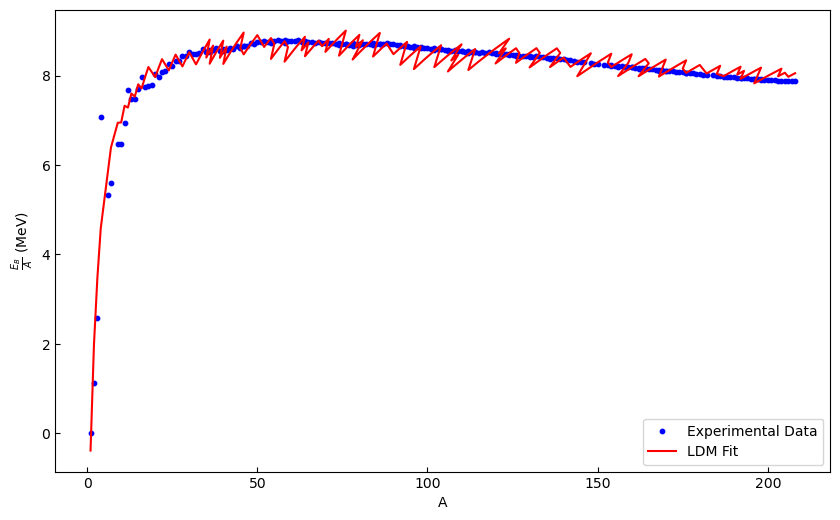

Fitted Liquid Drop Model Parameters:
a_v = 16.074045 MeV
a_s = 17.769354 MeV
a_c = 0.942769 MeV
a_a = -1.303203 MeV

Uncertainties in Parameters:
σ(a_v) = 0.233173 MeV
σ(a_s) = 0.480007 MeV
σ(a_c) = 0.033754 MeV
σ(a_a) = 0.371876 MeV


In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Function to compute binding energy using the Liquid Drop Model function
def liquid_drop_model(inputs, a_v, a_s, a_c, a_a):
    """
    Liquid Drop Model that takes both A and Z as inputs.
    Parameters:
        inputs : tuple containing (A, Z).
        a_v    : Volume energy coefficient.
        a_s    : Surface energy coefficient.
        a_c    : Coulomb energy coefficient.
        a_a    : Asymmetry energy coefficient.
    Returns:
        Binding energy per nucleon (E_b / A).
    """
    A, Z = inputs
    return (a_v
            - a_s * A ** (-1/3)
            - a_c * Z * (Z - 1) * A ** (-4/3)
            - a_a * ((A - 2 * Z) ** 2)/(A ** 2))

# Load the dataset
file_path = 'livechart.csv' 
df = pd.read_csv(file_path)

# Filter for stable nuclei only and extract necessary columns
df = df[df['half_life'] == 'STABLE']  # Filter for stable isotopes
df = df[['z', 'n', 'binding']].dropna()  # Keep relevant columns and drop NaNs

# Convert columns to numeric
df['z'] = df['z'].astype(int)  # Number of protons
df['n'] = df['n'].astype(int)  # Number of neutrons
df['binding'] = pd.to_numeric(df['binding'], errors='coerce')  # Binding energy in keV

# Compute the mass number A
df['A'] = df['z'] + df['n']

# Compute the binding energy per nucleon in MeV
df['binding_energy_per_nucleon'] = df['binding'] / 1000 

# Prepare inputs and target values
A = df['A'].values
Z = df['z'].values
binding_per_nucleon = df['binding_energy_per_nucleon'].values
inputs = (A, Z)  # Combine A and Z for the fitting process

# Initial guesses for the parameters
initial_guess = [1.0, 1.0, 0.0, 20.0]  # Reasonable starting guesses for a_v, a_s, a_c, a_a

# Fit the Liquid Drop Model to the data
popt, pcov = curve_fit(
    liquid_drop_model, inputs, binding_per_nucleon,
    p0=initial_guess,
    bounds=(-5, np.inf),  # Constrain parameters to non-negative values
    maxfev=100000 # Increase the number of iterations for convergence
)

# Extract the fitted parameters
a_v, a_s, a_c, a_a = popt

# Generate model predictions
ldm_fit = liquid_drop_model(inputs, *popt)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(A, binding_per_nucleon, color='blue', s=10, label='Experimental Data')
plt.plot(A, ldm_fit, color='red', label='LDM Fit')
plt.xlabel('A')
plt.ylabel(r'$\frac{E_B}{A}$ (MeV)')
#plt.title('Binding Energy per Nucleon vs Mass Number A')
plt.legend()
plt.tick_params(axis='both', direction='in')


plt.show()

# Print the fitted parameters and uncertainties
print("Fitted Liquid Drop Model Parameters:")
print(f"a_v = {a_v:.6f} MeV")
print(f"a_s = {a_s:.6f} MeV")
print(f"a_c = {a_c:.6f} MeV")
print(f"a_a = {a_a:.6f} MeV")

# Compute and print parameter uncertainties
parameter_uncertainties = np.sqrt(np.diag(pcov))
print("\nUncertainties in Parameters:")
print(f"σ(a_v) = {parameter_uncertainties[0]:.6f} MeV")
print(f"σ(a_s) = {parameter_uncertainties[1]:.6f} MeV")
print(f"σ(a_c) = {parameter_uncertainties[2]:.6f} MeV")
print(f"σ(a_a) = {parameter_uncertainties[3]:.6f} MeV")

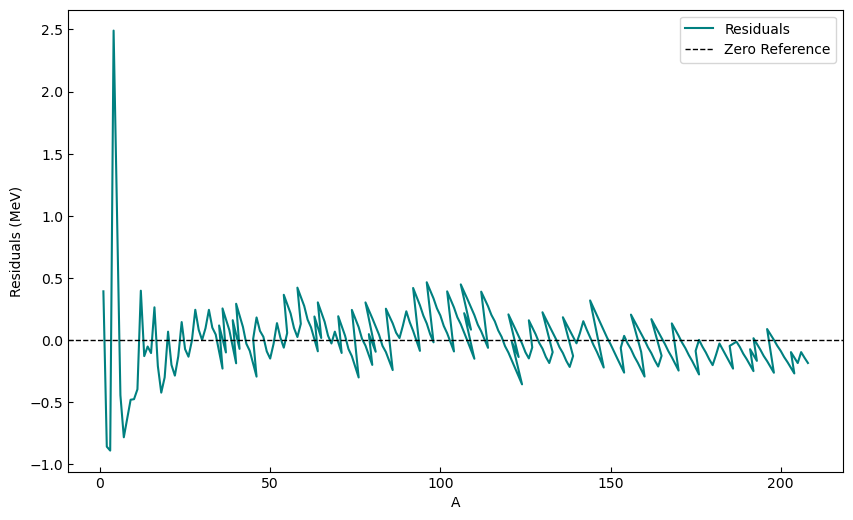

In [252]:
# Define previously fitted parameters
a_v, a_s, a_c, a_a = 16.074045, 17.769354, 0.942769, -1.303203

# Generate model predictions
ldm_fit = liquid_drop_model(inputs, a_v, a_s, a_c, a_a)

# Compute residuals
residuals = binding_per_nucleon - ldm_fit

# Plot residuals as a line
plt.figure(figsize=(10, 6))
plt.plot(A, residuals, color='teal', linewidth=1.5, label='Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Reference')  # Reference line at 0
plt.xlabel('A')
plt.ylabel('Residuals (MeV)')
plt.legend()
plt.tick_params(axis='both', direction='in')
#plt.grid(alpha=0.5, linestyle='--')

plt.show()

I tried to implement the parity term but I think it is not working well because I am not able to get any improvement.

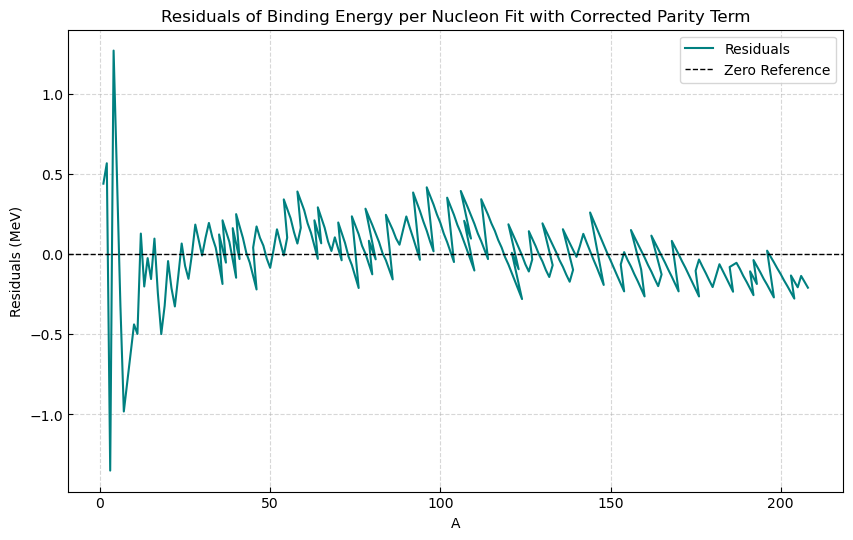

Fitted Liquid Drop Model Parameters with Parity Term:
a_v = 15.093701 MeV
a_s = 15.571371 MeV
a_c = 0.815032 MeV
a_a = -0.037073 MeV
a_p = 6.195242 MeV

Uncertainties in Parameters:
σ(a_v) = 0.227204 MeV
σ(a_s) = 0.477178 MeV
σ(a_c) = 0.032198 MeV
σ(a_a) = 0.348402 MeV
σ(a_p) = 0.672597 MeV


In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Corrected Liquid Drop Model with parity term
def liquid_drop_model_with_parity(inputs, a_v, a_s, a_c, a_a, a_p):
    A, Z = inputs
    N = A - Z  # Number of neutrons

    # Compute pairing term (δ)
    delta = np.where((Z % 2 == 0) & (N % 2 == 0), 1,
                     np.where(A % 2 != 0, 0,
                     np.where((Z % 2 != 0) & (N % 2 != 0), -1, 0)))

    # Total binding energy
    binding_energy = (
        a_v * A
        - a_s * A ** (2 / 3)
        - a_c * Z * (Z - 1) / A ** (1 / 3)  # Fixed Coulomb term
        - a_a * (A - 2 * Z) ** 2 / A
        + a_p * delta / A ** (1 / 2)        # Fixed parity term
    )

    # Binding energy per nucleon
    binding_energy_per_nucleon = binding_energy / A

    return binding_energy_per_nucleon

# Reload the dataset
file_path = 'livechart.csv'  # Update with the correct file path
df = pd.read_csv(file_path)

# Filter for stable nuclei only
df = df[df['half_life'] == 'STABLE']
df = df[['z', 'n', 'binding']].dropna()

# Ensure data types are integers for Z, N, and A
df['z'] = df['z'].astype(int)
df['n'] = df['n'].astype(int)
df['binding'] = pd.to_numeric(df['binding'], errors='coerce')
df['A'] = df['z'] + df['n']

# Compute the binding energy per nucleon in MeV
df['binding_energy_per_nucleon'] = df['binding'] / 1000

# Prepare inputs for curve fitting
A = df['A'].values
Z = df['z'].values
binding_per_nucleon = df['binding_energy_per_nucleon'].values
inputs = (A, Z)

# Initial guesses for the parameters
initial_guess = [15.5, 17.8, 0.7, 23.0, 12.0]  # Adjusted initial guesses

# Perform the fit
popt, pcov = curve_fit(
    liquid_drop_model_with_parity, inputs, binding_per_nucleon,
    p0=initial_guess,
    bounds=(-np.inf, np.inf),
    maxfev=100000
)

# Extract fitted parameters
a_v, a_s, a_c, a_a, a_p = popt

# Generate predictions and residuals
ldm_fit = liquid_drop_model_with_parity(inputs, *popt)
residuals = binding_per_nucleon - ldm_fit

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(A, residuals, color='teal', linewidth=1.5, label='Residuals')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Reference')
plt.xlabel('A')
plt.ylabel('Residuals (MeV)')
plt.title('Residuals of Binding Energy per Nucleon Fit with Corrected Parity Term')
plt.legend()
plt.grid(alpha=0.5, linestyle='--')
plt.tick_params(axis='both', direction='in')
plt.show()

# Print results
print("Fitted Liquid Drop Model Parameters with Parity Term:")
print(f"a_v = {a_v:.6f} MeV")
print(f"a_s = {a_s:.6f} MeV")
print(f"a_c = {a_c:.6f} MeV")
print(f"a_a = {a_a:.6f} MeV")
print(f"a_p = {a_p:.6f} MeV")

# Print uncertainties
parameter_uncertainties = np.sqrt(np.diag(pcov))
print("\nUncertainties in Parameters:")
print(f"σ(a_v) = {parameter_uncertainties[0]:.6f} MeV")
print(f"σ(a_s) = {parameter_uncertainties[1]:.6f} MeV")
print(f"σ(a_c) = {parameter_uncertainties[2]:.6f} MeV")
print(f"σ(a_a) = {parameter_uncertainties[3]:.6f} MeV")
print(f"σ(a_p) = {parameter_uncertainties[4]:.6f} MeV")


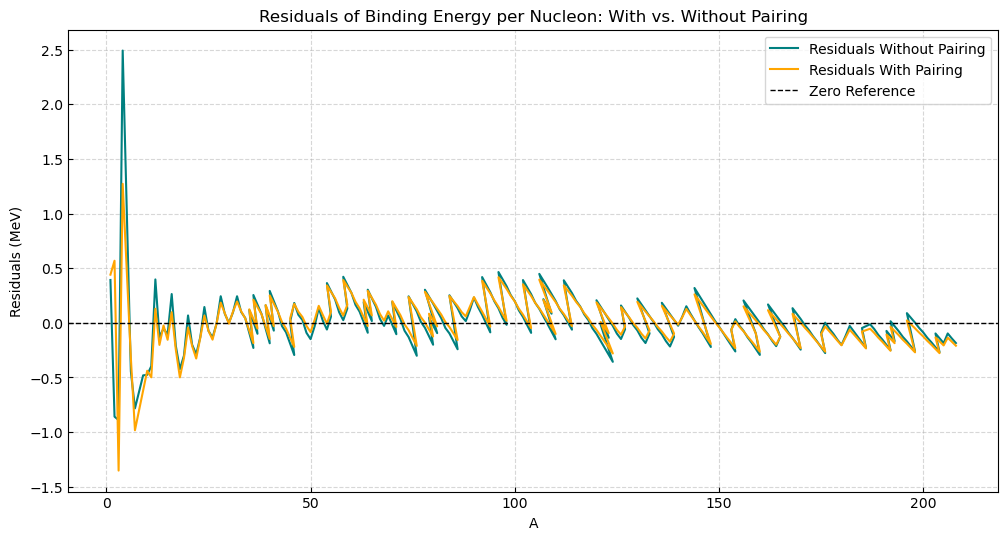

In [254]:

# Define parameters without pairing
params_without_pairing = [16.074045, 17.769354, 0.942769, -1.303203]

# Define parameters with pairing
params_with_pairing = [15.093701, 15.571371, 0.815032, -0.037073, 6.195242]


# Generate predictions without pairing
ldm_fit_no_pairing = liquid_drop_model(inputs, *params_without_pairing)
residuals_no_pairing = binding_per_nucleon - ldm_fit_no_pairing

# Generate predictions with pairing
ldm_fit_with_pairing = liquid_drop_model_with_parity(inputs, *params_with_pairing)
residuals_with_pairing = binding_per_nucleon - ldm_fit_with_pairing

# Plot residuals
plt.figure(figsize=(12, 6))

# Residuals without pairing
plt.plot(A, residuals_no_pairing, color='teal', linewidth=1.5, label='Residuals Without Pairing')

# Residuals with pairing
plt.plot(A, residuals_with_pairing, color='orange', linewidth=1.5, label='Residuals With Pairing')

# Reference line
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Reference')

# Plot styling
plt.xlabel('A')
plt.ylabel('Residuals (MeV)')
plt.title('Residuals of Binding Energy per Nucleon: With vs. Without Pairing')
plt.legend()
plt.tick_params(axis='both', direction='in')
plt.grid(alpha=0.5, linestyle='--')

plt.show()

## Bounty 8

The first 5 zeros of the spherical Bessel function of order 0: [3.141592653589793, 6.283185307179579, 9.42477796076938, 12.566370614359172]


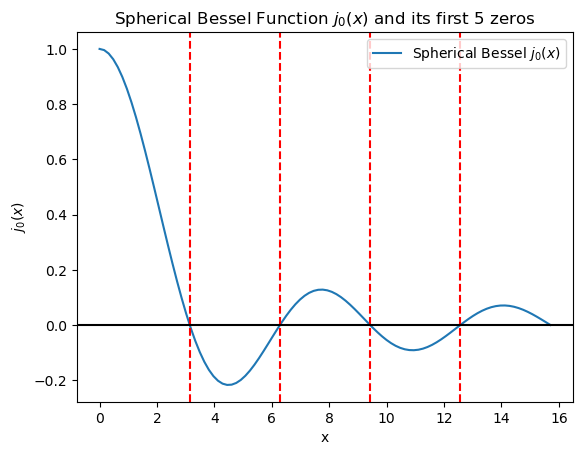

In [100]:
from scipy.optimize import root
import numpy as np
from scipy.special import spherical_jn
import matplotlib.pyplot as plt

def spherical_jn_sensible_grid(n, m, ngrid=100):
    """Returns an improved grid of x values to locate the first m zeros of spherical Bessel functions."""
    if n == 0:
        # For n=0, zeros are closer together; we use a tighter grid
        return np.linspace(0, m * np.pi, ngrid)
    else:
        # For n > 0, zeros are spaced further apart
        factor = 2 * np.pi * (1 + 1 / (2 * n))  # Approximate zero spacing
        return np.linspace(n, n + m * factor, ngrid)

def spherical_jn_zeros(n, m, ngrid=100):
    """Returns the first m zeros of the spherical Bessel function of order n."""
    # Generate the improved grid
    x = spherical_jn_sensible_grid(n, m, ngrid=ngrid)
    y = spherical_jn(n, x)
    
    # Find the first m good initial guesses where y changes sign
    diffs = np.sign(y)[1:] - np.sign(y)[:-1]
    ind0s = np.where(diffs)[0][:m]  # First m sign changes
    x0s = x[ind0s]
    
    # Function to find roots
    def fn(x):
        return spherical_jn(n, x)
    
    # Refine guesses using root finding
    return [root(fn, x0).x[0] for x0 in x0s]

def show_spherical_jn_zeros(n, m, ngrid=100):
    """Graphical test for the spherical_jn_zeros function."""
    x = spherical_jn_sensible_grid(n, m, ngrid=ngrid)
    y = spherical_jn(n, x)
    
    plt.plot(x, y, label=f"Spherical Bessel $j_{n}(x)$")
    zeros = spherical_jn_zeros(n, m, ngrid=ngrid)
    [plt.axvline(x0, color='r', linestyle='--') for x0 in zeros]
    plt.axhline(0, color='k', linestyle='-')
    plt.title(f"Spherical Bessel Function $j_{n}(x)$ and its first {m} zeros")
    plt.xlabel("x")
    plt.ylabel(f"$j_{n}(x)$")
    plt.legend()
    plt.show()

# Example usage
n = 0  # Order of spherical Bessel function
m = 5  # Number of zeros to compute

# Compute and display zeros
zeros = spherical_jn_zeros(n, m)
print(f"The first {m} zeros of the spherical Bessel function of order {n}: {zeros}")

# Plot the function and zeros
show_spherical_jn_zeros(n, m)

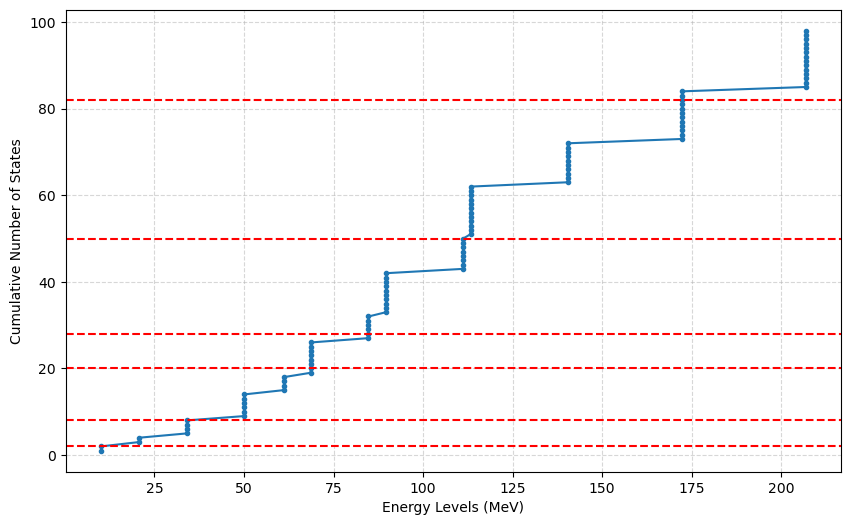

In [121]:
# Constants
hbar_c = 197.3269804  # Reduced Planck constant in MeV·fm
R = 4.5  # Radius of the spherical well in fm
m = 938.272  # Nucleon mass in MeV/c^2

# Function to calculate energy levels
def calculate_energy_levels(bessel_zeros, R, m):
    """
    Calculate the energy levels of a nucleon in a spherical potential well.
    
    Parameters:
        bessel_zeros (list): Zeros of the spherical Bessel function.
        R (float): Radius of the spherical well (in fm).
        m (float): Mass of the nucleon (in MeV/c^2).
    
    Returns:
        ndarray: Energy levels (in MeV).
    """
    return (np.array(bessel_zeros)**2 * hbar_c**2) / (2 * m * R**2)

# Compute energy levels for all l and account for degeneracies
def generate_energy_levels(max_l, max_zeros):
    energy_levels = []
    for l in range(max_l + 1):
        bessel_zeros = spherical_jn_zeros(l, max_zeros)  # Compute zeros
        energies = calculate_energy_levels(bessel_zeros, R, m)
        # Account for degeneracies (j = l ± 1/2)
        if l == 0:
            degeneracies = [2]  # Special case: only j = 1/2
        else:
            degeneracies = [2 * (j + 1) for j in [l - 1, l]] if l > 0 else [2]
        for e, d in zip(energies, degeneracies):
            energy_levels.extend([e] * d)  # Include degeneracy
    return sorted(energy_levels)

# Generate energy levels
max_l = 6
max_zeros = 10
energy_levels_all = generate_energy_levels(max_l, max_zeros)

# Compute cumulative states
cumulative_states = np.arange(1, len(energy_levels_all) + 1)


# Magic numbers
magic_numbers = [2, 8, 20, 28, 50, 82]

# Plot cumulative states vs energy
plt.figure(figsize=(10, 6))
plt.plot(energy_levels_all, cumulative_states, 'o-', label='Cumulative States',markersize=3)
for magic in magic_numbers:
    plt.axhline(y=magic, color='r', linestyle='--')
plt.xlabel('Energy Levels (MeV)')
plt.ylabel('Cumulative Number of States')
plt.grid(alpha=0.5, linestyle='--')
#plt.title('')
#plt.legend()
plt.show()

In [122]:
def spin_orbit_term(l, j, lambda_factor):
    """
    Compute the spin-orbit energy correction.
    
    Parameters:
        l (int): Orbital angular momentum quantum number.
        j (float): Total angular momentum quantum number (l ± 1/2).
        lambda_factor (float): Strength of the spin-orbit interaction.
    
    Returns:
        float: Spin-orbit correction to the energy (in MeV).
    """
    s = 0.5  # Spin quantum number
    spin_coupling = j * (j + 1) - l * (l + 1) - s * (s + 1)
    return lambda_factor * spin_coupling

Debugging Spin-Orbit Corrections:
l=0, j=0.5, E_base=10.11, ΔE=-0.00, Degeneracy=2
l=0, j=0.5, E_base=40.45, ΔE=-0.00, Degeneracy=2
l=0, j=0.5, E_base=91.02, ΔE=-0.00, Degeneracy=2
l=0, j=0.5, E_base=161.81, ΔE=-0.00, Degeneracy=2
l=0, j=0.5, E_base=252.83, ΔE=-0.00, Degeneracy=2
l=0, j=0.5, E_base=364.08, ΔE=-0.00, Degeneracy=2
l=0, j=0.5, E_base=495.55, ΔE=-0.00, Degeneracy=2
l=0, j=0.5, E_base=647.25, ΔE=-0.00, Degeneracy=2
l=0, j=0.5, E_base=819.17, ΔE=-0.00, Degeneracy=2
l=1, j=0.5, E_base=20.69, ΔE=2.00, Degeneracy=2
l=1, j=1.5, E_base=20.69, ΔE=-1.00, Degeneracy=4
l=1, j=0.5, E_base=61.15, ΔE=2.00, Degeneracy=2
l=1, j=1.5, E_base=61.15, ΔE=-1.00, Degeneracy=4
l=1, j=0.5, E_base=121.83, ΔE=2.00, Degeneracy=2
l=1, j=1.5, E_base=121.83, ΔE=-1.00, Degeneracy=4
l=1, j=0.5, E_base=202.74, ΔE=2.00, Degeneracy=2
l=1, j=1.5, E_base=202.74, ΔE=-1.00, Degeneracy=4
l=1, j=0.5, E_base=303.87, ΔE=2.00, Degeneracy=2
l=1, j=1.5, E_base=303.87, ΔE=-1.00, Degeneracy=4
l=1, j=0.5, E_base=425.23, Δ

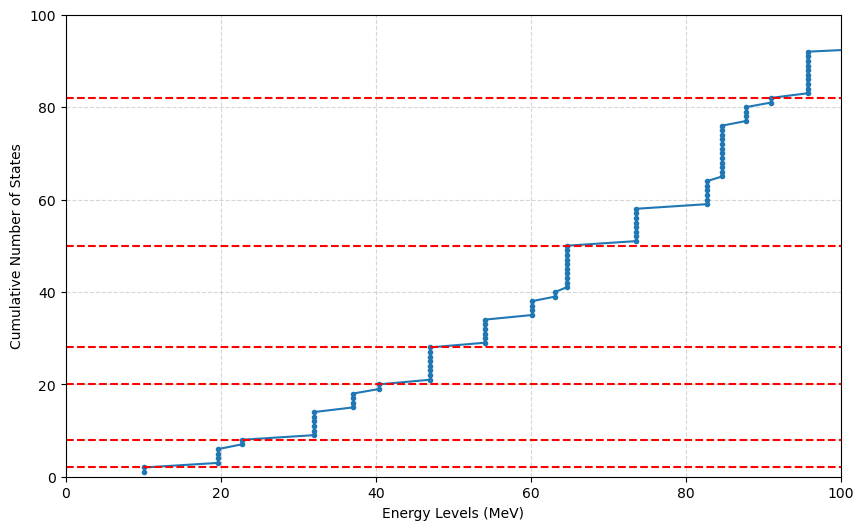

In [127]:
lambda_factor = -1.0
def calculate_corrected_energy_levels_debug(max_l, max_zeros, lambda_factor):
    """
    Compute energy levels including spin-orbit corrections with debugging.
    """
    corrected_energy_levels = []
    print("Debugging Spin-Orbit Corrections:")
    for l in range(max_l + 1):
        bessel_zeros = spherical_jn_zeros(l, max_zeros)
        base_energies = calculate_energy_levels(bessel_zeros, R, m)
        for n, base_energy in enumerate(base_energies):
            if l == 0:
                # Only j = 0.5 is allowed for l = 0
                j = 0.5
                delta_E = spin_orbit_term(l, j, lambda_factor)
                degeneracy = 2  # Degeneracy for j = 0.5
                # Add the energy as a tuple (energy, l, j)
                corrected_energy_levels.extend([(base_energy + delta_E, l, j)] * degeneracy)
                print(f"l={l}, j={j}, E_base={base_energy:.2f}, ΔE={delta_E:.2f}, Degeneracy={degeneracy}")
            else:
                # For l > 0, include both j = l ± 1/2
                for j in [l - 0.5, l + 0.5]:
                    delta_E = spin_orbit_term(l, j, lambda_factor)
                    degeneracy = int(2 * j + 1)
                    # Add the energy as a tuple (energy, l, j)
                    corrected_energy_levels.extend([(base_energy + delta_E, l, j)] * degeneracy)
                    print(f"l={l}, j={j}, E_base={base_energy:.2f}, ΔE={delta_E:.2f}, Degeneracy={degeneracy}")
    return sorted(corrected_energy_levels, key=lambda x: x[0])  # Sort by energy

max_l = 5
max_zeros = 10

# Compute corrected energy levels
corrected_energy_levels_debug = calculate_corrected_energy_levels_debug(max_l, max_zeros, lambda_factor=lambda_factor)

# Extract energy values for plotting
corrected_energies_debug = [level[0] for level in corrected_energy_levels_debug]

# Compute cumulative states
cumulative_states_debug = np.arange(1, len(corrected_energies_debug) + 1)

# Plot cumulative states vs energy
plt.figure(figsize=(10, 6))
plt.plot(corrected_energies_debug, cumulative_states_debug, 'o-', label='Cumulative States (Debugging)',markersize=3)
for magic in magic_numbers:
    plt.axhline(y=magic, color='r', linestyle='--', label=f'Magic Number {magic}' if magic == magic_numbers[0] else "")
plt.xlabel('Energy Levels (MeV)')
plt.ylabel('Cumulative Number of States')
#plt.title('Cumulative Number of States vs Energy (Debugging Spin-Orbit Interaction)')
#plt.legend()
plt.xlim(0, 100)  # Limit x-axis for better visibility
plt.ylim(0, 100)  # Limit y-axis for better visibility
plt.grid(alpha=0.5, linestyle='--')
plt.show()

Debugging Spin-Orbit Corrections:
l=0, j=0.5, E_base=9.68, ΔE=-0.00, Degeneracy=2
l=0, j=0.5, E_base=38.71, ΔE=-0.00, Degeneracy=2
l=0, j=0.5, E_base=87.10, ΔE=-0.00, Degeneracy=2
l=0, j=0.5, E_base=154.85, ΔE=-0.00, Degeneracy=2
l=0, j=0.5, E_base=241.96, ΔE=-0.00, Degeneracy=2
l=0, j=0.5, E_base=348.42, ΔE=-0.00, Degeneracy=2
l=0, j=0.5, E_base=474.24, ΔE=-0.00, Degeneracy=2
l=0, j=0.5, E_base=619.41, ΔE=-0.00, Degeneracy=2
l=0, j=0.5, E_base=783.94, ΔE=-0.00, Degeneracy=2
l=1, j=0.5, E_base=19.80, ΔE=2.00, Degeneracy=2
l=1, j=1.5, E_base=19.80, ΔE=-1.00, Degeneracy=4
l=1, j=0.5, E_base=58.52, ΔE=2.00, Degeneracy=2
l=1, j=1.5, E_base=58.52, ΔE=-1.00, Degeneracy=4
l=1, j=0.5, E_base=116.59, ΔE=2.00, Degeneracy=2
l=1, j=1.5, E_base=116.59, ΔE=-1.00, Degeneracy=4
l=1, j=0.5, E_base=194.02, ΔE=2.00, Degeneracy=2
l=1, j=1.5, E_base=194.02, ΔE=-1.00, Degeneracy=4
l=1, j=0.5, E_base=290.81, ΔE=2.00, Degeneracy=2
l=1, j=1.5, E_base=290.81, ΔE=-1.00, Degeneracy=4
l=1, j=0.5, E_base=406.95, ΔE

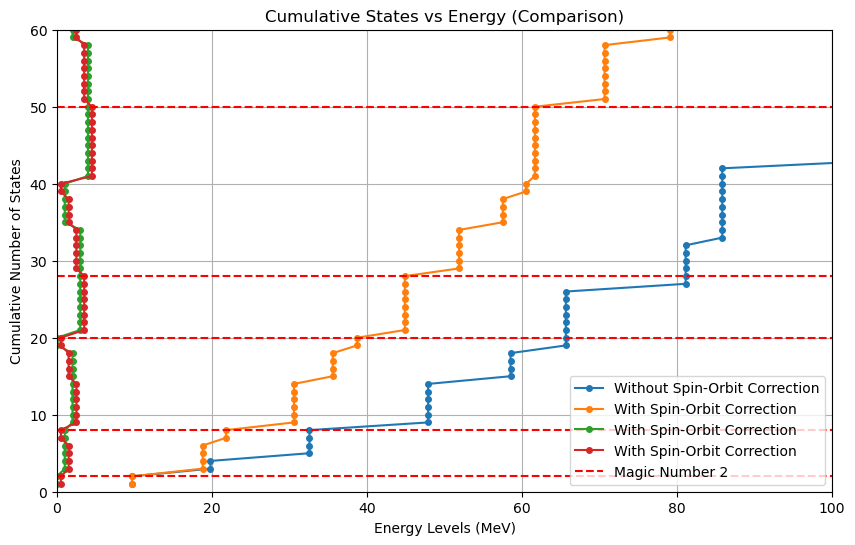

In [115]:
# Parameters
max_l = 5
max_zeros = 10
lambda_factor = -1
magic_numbers = [2, 8, 20, 28, 50, 82]

# Compute energy levels
uncorrected_energy_levels = generate_energy_levels(max_l, max_zeros)
corrected_energy_levels_kk = calculate_corrected_energy_levels_debug(max_l, max_zeros, lambda_factor)

# Compute cumulative states
cumulative_states_uncorrected = np.arange(1, len(uncorrected_energy_levels) + 1)
cumulative_states_corrected_kk = np.arange(1, len(corrected_energy_levels_kk) + 1)

# Plot both on the same graph
plt.figure(figsize=(10, 6))
plt.plot(uncorrected_energy_levels, cumulative_states_uncorrected, 'o-', label='Without Spin-Orbit Correction', markersize=4)
plt.plot(corrected_energy_levels_kk, cumulative_states_corrected_kk, 'o-', label='With Spin-Orbit Correction', markersize=4)

# Add magic numbers as horizontal lines
for magic in magic_numbers:
    plt.axhline(y=magic, color='r', linestyle='--', label=f'Magic Number {magic}' if magic == magic_numbers[0] else "")

# Labels and title
plt.xlabel('Energy Levels (MeV)')
plt.ylabel('Cumulative Number of States')
plt.title('Cumulative States vs Energy (Comparison)')
plt.legend()
plt.xlim(0, 100)  # Adjust as needed
plt.ylim(0, 60)  # Adjust as needed
plt.grid()

plt.show()